In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

初始化模型参数

In [18]:
def get_params(vocab_size, num_hiddens, device):
    # 神经网络的输入和输出维度都是词汇表的大小
    num_inputs = num_outputs = vocab_size
    # 初始化权重参数
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    # 批量处理权重参数
    def three():
        return (normal((num_inputs, num_hiddens)), 
               normal((num_hiddens, num_hiddens)),
               torch.zeros(num_hiddens, device=device))
    # 遗忘门
    W_xf, W_hf, b_f = three()
    # 输入门
    W_xi, W_hi, b_i = three()
    # 输出门
    W_xo, W_ho, b_o = three()
    # 候选记忆状态
    W_xc, W_hc, b_c = three()
    
    #输出层
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xf, W_hf, b_f, W_xi, W_hi, b_i, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q]
    
    # 求取梯度
    for param in params:
        param.requires_grad_(True)
        
    return params

初始化隐状态，因为LSTM中多了一项记忆单元，因此隐状态为tuple而不是一个单一的矩阵

In [20]:
def lstm_init_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
           torch.zeros((batch_size, num_hiddens), device=device))

计算一个LSTM单元的输出

In [23]:
def lstm(input, state, params):
    [W_xf, W_hf, b_f, W_xi, W_hi, b_i, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q] = params
    H, C  = state
    output = []
    
    for X in input:
        # 遗忘门
        F = torch.sigmoid(X @ W_xf + H @ W_hf + b_f)
        # 输入门
        I = torch.sigmoid(X @ W_xi + H @ W_hi + b_i)
        # 输出门
        O = torch.sigmoid(X @ W_xo + H @ W_ho + b_o)
        # 候选记忆体
        C_tilda = torch.tanh(X @ W_xc + H @ W_hc + b_c)
        # 记忆元
        C = F * C + I * C_tilda
        # 隐状态
        H =  O * torch.tanh(C)
        # 输出
        Y = H @ W_hq + b_q
        output.append(Y)
    
    return torch.cat(output, dim=0), (H, C)

训练

perplexity 1.2, 11761.4 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller chifle not a whisher oflers now you wain the payo


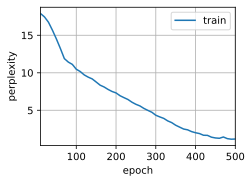

In [24]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_params, lstm_init_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

perplexity 1.1, 98219.6 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


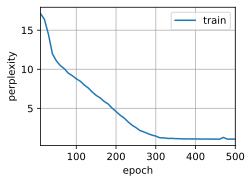

In [26]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)